# Task Advanced. Clustering of crimen locations

## Module 11. Scalable Data processing: Machine learning and Streaming

## Pablo Yañez Martin

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.ml.clustering import KMeans, KMeansModel
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
import folium
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

In [2]:
spark_session = SparkSession \
    .builder \
    .appName("Task Advanced: Clustering of crimen locations") \
    .master("local[*]") \
    .getOrCreate()

In [3]:
data = spark_session \
    .read \
    .format("csv") \
    .option("header", "true")\
    .load("D:\Dropbox\Pablo\Master\Modulo 11. Scalable Data processing. Machine Learning and Streaming\Tareas\Tarea Advaced 2\Crimes_-_2001_to_Present.csv")

Checking if the data has been loaded correctly.

In [4]:
data.printSchema()
data.show()

root
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Location: string (nullable = true)

+--------+-----------+--------------------+--------------------+----+------------------+------------------

Now, we will search the primary type which has more incidents.

In [5]:
data\
    .groupBy("Primary Type")\
    .count()\
    .orderBy("count",ascending=False)

data\
    .show(1)

+--------+-----------+--------------------+---------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|                Date|          Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+--------------------+---------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10224738|   HY411648|09/05/2015 01:30:...|043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     009|  12|         

As we can observe, the result is THEFT.

In the following cell we are doing a filter of the data, because we only want the crimes whose primary type is theft. And, we will remove those locations that are nulls.

In [6]:
thefts = data\
    .filter(data["Primary Type"]=="THEFT")\
    .filter(data["Location"].isNotNull())

thefts.show()

+--------+-----------+--------------------+--------------------+----+------------+--------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|                Date|               Block|IUCR|Primary Type|   Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+--------------------+--------------------+----+------------+--------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10224739|   HY411615|09/04/2015 11:30:...| 008XX N CENTRAL AVE|0870|       THEFT|POCKET-PICKING|             CTA BUS| false|   false|1511|     015|  29|            2

As we are only interested in the features, latitude and longitude, we will create a new dataframe with these features.

In [7]:
coordinates = thefts\
    .select("Latitude", "Longitude")

coordinates.show()

+------------+-------------+
|    Latitude|    Longitude|
+------------+-------------+
|41.895080471|-87.765400451|
|41.851988885|-87.689219118|
|41.763647552|-87.722344693|
|41.907127255|-87.678232016|
|41.752596188|-87.554055126|
|41.875367424|-87.627620993|
|41.901851233|-87.667456951|
|41.763647552|-87.722344693|
|41.772613371|-87.636098706|
| 41.90444226| -87.63293969|
|41.876607964|-87.627644063|
|41.873861861| -87.68895549|
|41.742177899|-87.560010869|
|41.863235129|-87.624061274|
|41.832071291|-87.616978684|
|41.751613643|-87.575373855|
|41.685021672|-87.618008151|
| 41.90706989|-87.648182264|
|41.700055116|-87.702338239|
|41.803227125|-87.658359911|
+------------+-------------+
only showing top 20 rows



In order to use this dataframe, we have to change the type of the features from string to float. I have followed the instructions from this URL: https://stackoverflow.com/questions/47585723/kmeans-clustering-in-pyspark/47593712

In [8]:
lista_de_coordenadas = []
col = coordinates.collect()
for i in range(len(col)):
    lista_de_coordenadas.append([i,float(col[i][0]),float(col[i][1])])

In [9]:
df = spark_session.createDataFrame(lista_de_coordenadas,["id","Latitude","Longitude"])

In [10]:
vecAssembler = VectorAssembler(inputCols=["Latitude", "Longitude"], outputCol="features")
new_df = vecAssembler.transform(df)
new_df.show()

+---+------------+-------------+--------------------+
| id|    Latitude|    Longitude|            features|
+---+------------+-------------+--------------------+
|  0|41.895080471|-87.765400451|[41.895080471,-87...|
|  1|41.851988885|-87.689219118|[41.851988885,-87...|
|  2|41.763647552|-87.722344693|[41.763647552,-87...|
|  3|41.907127255|-87.678232016|[41.907127255,-87...|
|  4|41.752596188|-87.554055126|[41.752596188,-87...|
|  5|41.875367424|-87.627620993|[41.875367424,-87...|
|  6|41.901851233|-87.667456951|[41.901851233,-87...|
|  7|41.763647552|-87.722344693|[41.763647552,-87...|
|  8|41.772613371|-87.636098706|[41.772613371,-87...|
|  9| 41.90444226| -87.63293969|[41.90444226,-87....|
| 10|41.876607964|-87.627644063|[41.876607964,-87...|
| 11|41.873861861| -87.68895549|[41.873861861,-87...|
| 12|41.742177899|-87.560010869|[41.742177899,-87...|
| 13|41.863235129|-87.624061274|[41.863235129,-87...|
| 14|41.832071291|-87.616978684|[41.832071291,-87...|
| 15|41.751613643|-87.575373

Now, I have studied which is the apropiate number of cluster to this problem. 

In [11]:
dataset = new_df.select("features")
y=[0.6862286052103499,0.538236470369552,0.5373711996549025,0.5041161305750761,0.5209507771054922,0.5832396654338698,0.5595816753151497,  0.5848868449192102, 0.5591301265407447,0.5583415991085846,0.5648774663775893,0.5630837365953455,0.5674995124679105,0.5544715951229879,0.5748381724698486,0.5711645853499316,0.5535652864225256,0.5413676750019638]
x=[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]

In [12]:
# It is only necessary to change the following number to compute the silhouette measure
n_clusters=20
kmeans = KMeans(k=n_clusters, seed=1)
model = kmeans.fit(dataset)

# Make predictions
predictions = model.transform(new_df)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))
y.append(silhouette)
x.append(n_clusters)

Silhouette with squared euclidean distance = 0.558903514132928


In the following cell, I have drawn the results, and we can conclude that the better quantity of cluster is 2, because has the maximum value in the following graphic.

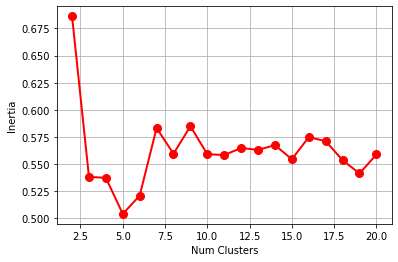

In [13]:
plt.plot(x, y, 'ro-', markersize=8, lw=2)
plt.grid(True)
plt.xlabel('Num Clusters')
plt.ylabel('Silhouette measure')
plt.show()

In [14]:
number_of_clusters = 2

In [15]:
kmeans = KMeans(k=number_of_clusters, seed=1)
model = kmeans.fit(new_df.select("features"))

In [16]:
transformed = model.transform(new_df)
transformed.show(truncate=False)

+---+------------+-------------+----------------------------+----------+
|id |Latitude    |Longitude    |features                    |prediction|
+---+------------+-------------+----------------------------+----------+
|0  |41.895080471|-87.765400451|[41.895080471,-87.765400451]|0         |
|1  |41.851988885|-87.689219118|[41.851988885,-87.689219118]|0         |
|2  |41.763647552|-87.722344693|[41.763647552,-87.722344693]|1         |
|3  |41.907127255|-87.678232016|[41.907127255,-87.678232016]|0         |
|4  |41.752596188|-87.554055126|[41.752596188,-87.554055126]|1         |
|5  |41.875367424|-87.627620993|[41.875367424,-87.627620993]|0         |
|6  |41.901851233|-87.667456951|[41.901851233,-87.667456951]|0         |
|7  |41.763647552|-87.722344693|[41.763647552,-87.722344693]|1         |
|8  |41.772613371|-87.636098706|[41.772613371,-87.636098706]|1         |
|9  |41.90444226 |-87.63293969 |[41.90444226,-87.63293969]  |0         |
|10 |41.876607964|-87.627644063|[41.876607964,-87.6

In [17]:
#model.save("K-Means Crimen Locations")

In [18]:
locations_per_cluster=transformed\
    .groupBy("prediction")\
    .count()\
    .orderBy("prediction")

In [19]:
cluster_num_locations=[]

centers = model.clusterCenters()

i=0
for (x,y) in locations_per_cluster.collect():
    cluster_num_locations.append([x,y,centers[i]])
    i+=1
    
cluster_num_locations=(sorted(cluster_num_locations))
print(cluster_num_locations)

[[0, 954449, array([ 41.91529452, -87.68575324])], [1, 568413, array([ 41.76324405, -87.63976608])]]


In [20]:
for (cluster, size, centroid) in cluster_num_locations:
    print("Cluster: "+str(cluster)+",\t"+ "Centroid: "+str(centroid)+",\t"+"Size of the cluster: "+str(size))    

Cluster: 0,	Centroid: [ 41.91529452 -87.68575324],	Size of the cluster: 954449
Cluster: 1,	Centroid: [ 41.76324405 -87.63976608],	Size of the cluster: 568413


In [21]:
print(str(model.hasSummary))

True


In [22]:
mapa = folium.Map(location=(41.888048, -87.526434), zoom_start=11)

In [23]:
for (cluster, size, centroid) in cluster_num_locations:
    coordenada = (centroid[0], centroid[1])
    marcador = folium.Marker(location=coordenada, popup="Cluster: "+str(cluster)+"\n"+"Center: "+str(centroid)+"\n"+"Size of the cluster: "+str(size),icon=folium.Icon(color='blue'))
    marcador.add_to(mapa)

In [24]:
folium.LayerControl().add_to(mapa)

In [25]:
mapa.save(outfile='D:\Dropbox\Pablo\Master\Modulo 11. Scalable Data processing. Machine Learning and Streaming\Tareas\Tarea Advaced 2\mapa.html')

In [26]:
mapa

In [27]:
spark_session.stop()